## **Histogram equalization**


In [2]:
!pip install opencv-python

  Using cached opencv_python-4.5.1.48-cp37-cp37m-manylinux2014_x86_64.whl (50.4 MB)


In [1]:
import numpy as np
import cv2
%matplotlib inline
#Comment: The purpose of the above line is to display matplotlib plots inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
img=cv2.imread('./SOTS/indoor/gt/1400.png')
img1=cv2.imread('./SOTS/indoor/hazy/1400_1.png')

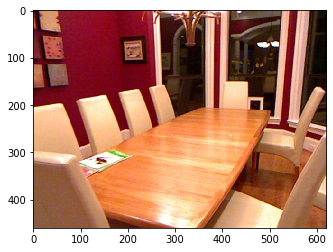

In [3]:

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Text(0.5, 1.0, 'Hazy')

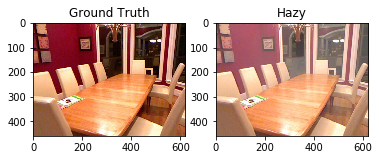

In [4]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Hazy")


Text(0.5, 1.0, 'haze')

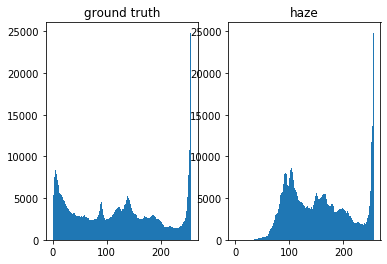

In [5]:
plt.subplot(1,2,1)
plt.hist(img.ravel(),256,[0,256])

plt.title("ground truth")
plt.subplot(1,2,2)
plt.hist(img1.ravel(),256,[0,256])
plt.title("haze")

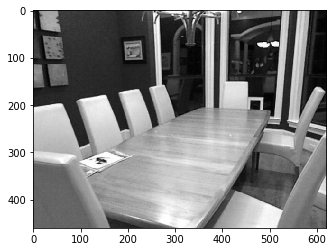

In [6]:
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap='gray')

Text(0.5, 1.0, 'eqalized')

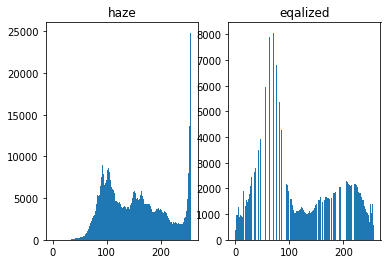

In [7]:
img1_eq=cv2.equalizeHist(cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY))

plt.subplot(1,2,1)
plt.hist(img1.ravel(),256,[0,256])
plt.title("haze")

plt.subplot(1,2,2)
plt.hist(img1_eq.ravel(),256,[0,256])
plt.title("eqalized")

# **Histogram equalization colour**

In [8]:
img1_hsv=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
img1_hsv[:,:,2]=cv2.equalizeHist(img1_hsv[:,:,2])
img1_eq=cv2.cvtColor(img1_hsv,cv2.COLOR_HSV2BGR)

Text(0.5, 1.0, 'equalized')

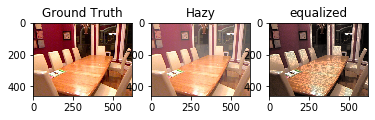

In [14]:
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth")
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Hazy")
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img1_hsv, cv2.COLOR_HSV2RGB))
plt.title("equalized")


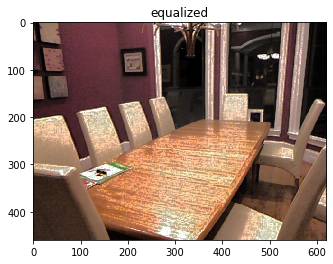

In [15]:
plt.imshow(cv2.cvtColor(img1_hsv, cv2.COLOR_HSV2RGB))
plt.title("equalized")
plt.savefig("histeq.png")

# *Simple GAN*

In [1]:
import numpy as np
import cv2
%matplotlib inline
#Comment: The purpose of the above line is to display matplotlib plots inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

## Genarator

In [19]:
class Generator(tf.keras.Model):
    def __init__(self,num_classes,channels=1):
        super(Generator,self).__init__()
        self.channels=channels
        self.dense_z=tf.keras.layers.Dense(256,activation='relu')
        self.dropout_z=tf.keras.layers.Dropout(0.5)
        
        self.dense_y=tf.keras.layers.Dense(256,activation='relu')
        self.dropout_y=tf.keras.layers.Dropout(0.5)
        
        self.combined_dense=tf.keras.layers.Dense(512,activation='relu')
        self.dropout_x=tf.keras.layers.Dropout(0.5)
        
        self.final_dense=tf.keras.layers.Dense(28*28*self.channels,activation='tanh')
        self.reshape=tf.keras.layers.Reshape((28,28,self.channels))
        
    def call(self,inputs,labels,training=True):
        z=self.dense_z(inputs)
        y=self.dense_y(labels)
        combined_x=self.combined_dense(tf.concat([z,y],axis=-1))
        x=self.final_dense(combined_x)
        
        return self.reshape(x)

## Discriminator

In [20]:
class MaxoutDense(tf.keras.layers.Layer):
    def __init__(self,units,k,activation,drop_prob=0.5):
        self.dense=tf.keras.layers.Dense(units*k,activation=activation)
        self.dropout=tf.keras.layers.Dropout(drop_prob)
        self.reshape=tf.keras.layers.Reshape((-1,k,units))
        super(MaxoutDense,self).__init__()
    def call(self,inputs,training=True):
        x=self.dense(inputs)
        x=self.dropout(x,training)
        x=self.reshape(x)
        return tf.reduce_max(x,axis=1)

In [27]:
class Discriminator(tf.keras.Model):
    def __init__(self,num_classes):
        super(Discriminator,self).__init__()
        self.flatten=tf.keras.layers.Flatten()
        self.maxout_z=MaxoutDense(240,k=5,activation='relu',drop_prob=0.5)
        self.maxout_y = MaxoutDense(50, k=5, activation='relu', drop_prob=0.5)
        self.maxout_x = MaxoutDense(240, k=4, activation='relu', drop_prob=0.5)
        self.out=tf.keras.layers.Dense(1)
        
    def call(self,inputs,labels,training=True):
        z=self.flatten(inputs)
        z=self.maxout_z(z,training)
        y=self.maxout_y(labels,training)
        x=self.maxout_x(tf.concat([z,y],axis=-1))
        return self.out(x)

## utils

In [28]:
def discriminator_loss(loss_object, real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(loss_object, fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)


def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image


def resize(image, height, width):
    image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image


def convert_onehot(label, num_classes):
    return tf.one_hot(label, num_classes)


def preprocess_image(data, img_shape, num_classes):
    image = data['image']
    image = resize(image, img_shape[0], img_shape[1])
    image = normalize(image)

    label = convert_onehot(data['label'], num_classes)

    return image, label


def save_imgs(epoch, generator, noise):
    # You can set it you want.
    labels = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 1
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # 2
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # 3
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 4
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # 5
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # 6
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 7
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # 8
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # 9
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # 10
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # 11
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # 12
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 13
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # 14
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # 15
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 16
              ]
    labels = tf.convert_to_tensor(labels)
    gen_imgs = generator(noise, labels, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    fig.savefig("images/mnist_%d.png" % epoch)

## training

In [29]:
# !pip install tensorflow_datasets

In [30]:
import os
import time

import tensorflow as tf  
import tensorflow_datasets as tfds



In [31]:
def train():
    # data, info = tfds.load("lsun/bedroom", with_info=True, data_dir='/data/tensorflow_datasets')
    data, info = tfds.load("mnist", with_info=True, data_dir='./data/tensorflow_datasets')
    train_data = data['train']

    if not os.path.exists('./images'):
        os.makedirs('./images')

    # settting hyperparameter
    latent_dim = 100
    epochs = 800
    batch_size = 200
    buffer_size = 6000
    save_interval = 50

    img_shape = (28, 28, 1)

    num_classes = info.features['label'].num_classes

    generator = Generator(num_classes)
    discriminator = Discriminator(num_classes)

    gen_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
    disc_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

    train_dataset = train_data.map(lambda x: preprocess_image(x, img_shape, num_classes)).shuffle(buffer_size).batch(batch_size)

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    @tf.function
    def train_step(images, labels):
        noise = tf.random.normal([batch_size, latent_dim])

        with tf.GradientTape(persistent=True) as tape:
            generated_images = generator(noise, labels)

            real_output = discriminator(images, labels)
            generated_output = discriminator(generated_images, labels)

            gen_loss = generator_loss(cross_entropy, generated_output)
            disc_loss = discriminator_loss(cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)
        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

        return gen_loss, disc_loss

    seed = tf.random.normal([16, latent_dim])

    for epoch in range(1, epochs + 1):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0

        for images, labels in train_dataset:
            gen_loss, disc_loss = train_step(images, labels)

            total_gen_loss += gen_loss
            total_disc_loss += disc_loss

        print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}'.format(epoch, time.time() - start, total_gen_loss / batch_size, 
total_disc_loss / batch_size))
        if epoch % save_interval == 0:
            save_imgs(epoch, generator, seed)

In [32]:
train()

Time for epoch 1 is 37.243647813797 sec - gen_loss = 2.6091115474700928, disc_loss = 0.7769707441329956
Time for epoch 2 is 31.21509289741516 sec - gen_loss = 5.519206523895264, disc_loss = 0.20882539451122284
Time for epoch 3 is 31.64405059814453 sec - gen_loss = 5.84343147277832, disc_loss = 0.149375781416893


KeyboardInterrupt: 